# Speed test of the EGNN implementation for the original paper [1] versus our jax implementation
[1] Satorras, V. G., Hoogeboom, E., & Welling, M. (2021). E(n) Equivariant Graph Neural Networks. In Proceedings of the 38th International Conference on Machine Learning, 139. https://doi.org/10.48550/ARXIV.2102.09844

Some of the code has been adapted from the following source: https://github.com/maxxxzdn/jax-geometric by Maksim Zhdanov.

## 1. Load up the repositories

In [1]:
import os
from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import userdata
    repo_name = 'vgsatorras/egnn'
    url = f"https://{userdata.get('gh_pat')}@github.com/{repo_name}.git"
    !git clone --branch main {url}
    #%cd egnn

Cloning into 'egnn'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 92 (delta 10), reused 4 (delta 4), pack-reused 66
Receiving objects: 100% (92/92), 297.25 KiB | 3.62 MiB/s, done.
Resolving deltas: 100% (17/17), done.

Current Directory:
[Errno 2] No such file or directory: 'egnn-transformer'
/content


In [ ]:
import os
from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import userdata
    repo_name = 'stefanvasilev/egnn-transformer'
    url = f"https://{userdata.get('gh_pat')}@github.com/{repo_name}.git"
    !git clone --branch main {url}
    #%cd egnn-transformer


## 2. Timing test of the Pytorch EGNN

In [2]:
%cd egnn

/content/egnn


Nodes: 5:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([160, 15]) torch.Size([160, 3]) torch.Size([640])
Num. params: 758657


Nodes: 5: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Nodes: 5, Mean Duration: 0.00470 s, Std Duration: 0.000760 s


Nodes: 10:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([320, 15]) torch.Size([320, 3]) torch.Size([2880])
Num. params: 758657


Nodes: 10: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Nodes: 10, Mean Duration: 0.00474 s, Std Duration: 0.000716 s


Nodes: 15:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([480, 15]) torch.Size([480, 3]) torch.Size([6720])
Num. params: 758657


Nodes: 15: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


Nodes: 15, Mean Duration: 0.00692 s, Std Duration: 0.002395 s


Nodes: 20:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([640, 15]) torch.Size([640, 3]) torch.Size([12160])
Num. params: 758657


Nodes: 20: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Nodes: 20, Mean Duration: 0.00912 s, Std Duration: 0.002581 s


Nodes: 25:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([800, 15]) torch.Size([800, 3]) torch.Size([19200])
Num. params: 758657


Nodes: 25: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Nodes: 25, Mean Duration: 0.01028 s, Std Duration: 0.000033 s


Nodes: 30:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([960, 15]) torch.Size([960, 3]) torch.Size([27840])
Num. params: 758657


Nodes: 30: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


Nodes: 30, Mean Duration: 0.01473 s, Std Duration: 0.000073 s


Nodes: 35:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1120, 15]) torch.Size([1120, 3]) torch.Size([38080])
Num. params: 758657


Nodes: 35: 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


Nodes: 35, Mean Duration: 0.02031 s, Std Duration: 0.000111 s


Nodes: 40:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1280, 15]) torch.Size([1280, 3]) torch.Size([49920])
Num. params: 758657


Nodes: 40: 100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Nodes: 40, Mean Duration: 0.02713 s, Std Duration: 0.000249 s


Nodes: 45:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1440, 15]) torch.Size([1440, 3]) torch.Size([63360])
Num. params: 758657


Nodes: 45: 100%|██████████| 10/10 [00:38<00:00,  3.90s/it]


Nodes: 45, Mean Duration: 0.03544 s, Std Duration: 0.000449 s


Nodes: 50:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1600, 15]) torch.Size([1600, 3]) torch.Size([78400])
Num. params: 758657


Nodes: 50: 100%|██████████| 10/10 [00:47<00:00,  4.72s/it]


Nodes: 50, Mean Duration: 0.04291 s, Std Duration: 0.000325 s


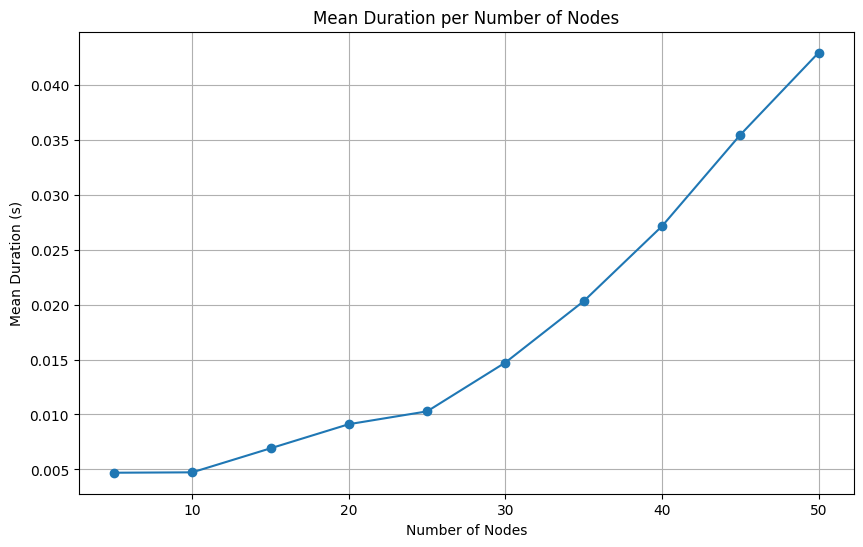

In [4]:
import argparse
import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from models.gcl import E_GCL, unsorted_segment_sum
from qm9.models import EGNN

parser = argparse.ArgumentParser()
parser.add_argument('--hidden_features', type=int, default=128)
parser.add_argument('--edge_features', type=int, default=1)
parser.add_argument('--out_features', type=int, default=1)
parser.add_argument('--n_layers', type=int, default=3)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--min_nodes', type=int, default=5)
parser.add_argument('--max_nodes', type=int, default=50)
parser.add_argument('--step_nodes', type=int, default=5)
parser.add_argument('--n_warmup', type=int, default=10)
parser.add_argument('--n_iter', type=int, default=100)
parser.add_argument('--n_measurements', type=int, default=10)
parser.add_argument('--output_file', type=str, default='timing_results.json')

#needed for collab
args, unknown = parser.parse_known_args()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# use Syntetic data
def get_edges(n_nodes):
    rows, cols = [], []
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j:
                rows.append(i)
                cols.append(j)
    return [rows, cols]

def get_edges_batch(n_nodes, batch_size):
    edges = get_edges(n_nodes)
    edge_attr = torch.ones(len(edges[0]) * batch_size, 1).to(device)
    edges = [torch.LongTensor(edges[0]).to(device), torch.LongTensor(edges[1]).to(device)]
    if batch_size == 1:
        return edges, edge_attr
    elif batch_size > 1:
        rows, cols = [], []
        for i in range(batch_size):
            rows.append(edges[0] + n_nodes * i)
            cols.append(edges[1] + n_nodes * i)
        edges = [torch.cat(rows), torch.cat(cols)]
    return edges, edge_attr


def run_timing_test(n_nodes):
    durations = []

    node_features = torch.randn((args.batch_size * n_nodes, 15), dtype=torch.float).to(device)  # We are testing for features dimension of 15
    node_positions = torch.randn((args.batch_size * n_nodes, 3), dtype=torch.float).to(device)
    node_mask = torch.ones((args.batch_size * n_nodes, 1), dtype=torch.float).to(device)
    edges, edge_attr = get_edges_batch(n_nodes, args.batch_size)
    edge_mask = torch.ones(len(edges[0]), 1).to(device)


    model = EGNN(
        in_node_nf=15,
        in_edge_nf=args.edge_features,
        hidden_nf=args.hidden_features,
        device=device,
        n_layers=args.n_layers
    ).to(device)

    for measurement in tqdm.tqdm(range(args.n_measurements), desc=f'Nodes: {n_nodes}'):

        if measurement == 0:
            print(node_features.shape, node_positions.shape, edges[0].shape)
            print('Num. params:', sum(p.numel() for p in model.parameters() if p.requires_grad))

        for _ in range(args.n_warmup):
            _ = model(node_features, node_positions, edges, edge_attr, node_mask, edge_mask, n_nodes)
        torch.cuda.synchronize()

        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()
        for _ in range(args.n_iter):
            _ = model(node_features, node_positions, edges, edge_attr, node_mask, edge_mask, n_nodes)
        end.record()
        torch.cuda.synchronize()

        durations.append(0.001 * start.elapsed_time(end) / args.n_iter)

    mean_duration = np.mean(durations)
    std_duration = np.std(durations)

    return mean_duration, std_duration

# Run Timing Tests for Different Node Counts, keep initial values for more comprehensive graphs
results = []
node_counts = list(range(args.min_nodes, args.max_nodes + 1, args.step_nodes))

for n_nodes in node_counts:
    mean_duration, std_duration = run_timing_test(n_nodes)
    results.append({
        'n_nodes': n_nodes,
        'mean_duration': mean_duration,
        'std_duration': std_duration
    })
    print(f'Nodes: {n_nodes}, Mean Duration: {mean_duration:.5f} s, Std Duration: {std_duration:.6f} s')


with open(args.output_file, 'w') as f:
    json.dump(results, f)

mean_durations = [result['mean_duration'] for result in results]
plt.figure(figsize=(10, 6))
plt.plot(node_counts, mean_durations, marker='o')
plt.xlabel('Number of Nodes')
plt.ylabel('Mean Duration (s)')
plt.title('Mean Duration per Number of Nodes - EGNN Pytorch')
plt.grid(True)
plt.savefig('timing_plot.png')
plt.show()

## 3. Timing test of the Jax EGNN

In [ ]:
%cd ../egnn-transformer

Nodes: 5:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([160, 15]) torch.Size([160, 3]) torch.Size([640])
Num. params: 354689


Nodes: 5: 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


Nodes: 5, Mean Duration: 0.00203 s, Std Duration: 0.000101 s


Nodes: 10:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([320, 15]) torch.Size([320, 3]) torch.Size([2880])
Num. params: 354689


Nodes: 10: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Nodes: 10, Mean Duration: 0.00285 s, Std Duration: 0.001038 s


Nodes: 15:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([480, 15]) torch.Size([480, 3]) torch.Size([6720])
Num. params: 354689


Nodes: 15: 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


Nodes: 15, Mean Duration: 0.00200 s, Std Duration: 0.000053 s


Nodes: 20:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([640, 15]) torch.Size([640, 3]) torch.Size([12160])
Num. params: 354689


Nodes: 20: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Nodes: 20, Mean Duration: 0.00305 s, Std Duration: 0.000033 s


Nodes: 25:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([800, 15]) torch.Size([800, 3]) torch.Size([19200])
Num. params: 354689


Nodes: 25: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Nodes: 25, Mean Duration: 0.00466 s, Std Duration: 0.000024 s


Nodes: 30:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([960, 15]) torch.Size([960, 3]) torch.Size([27840])
Num. params: 354689


Nodes: 30: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Nodes: 30, Mean Duration: 0.00664 s, Std Duration: 0.000027 s


Nodes: 35:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1120, 15]) torch.Size([1120, 3]) torch.Size([38080])
Num. params: 354689


Nodes: 35: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


Nodes: 35, Mean Duration: 0.00909 s, Std Duration: 0.000054 s


Nodes: 40:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1280, 15]) torch.Size([1280, 3]) torch.Size([49920])
Num. params: 354689


Nodes: 40: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


Nodes: 40, Mean Duration: 0.01195 s, Std Duration: 0.000060 s


Nodes: 45:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1440, 15]) torch.Size([1440, 3]) torch.Size([63360])
Num. params: 354689


Nodes: 45: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


Nodes: 45, Mean Duration: 0.01530 s, Std Duration: 0.000133 s


Nodes: 50:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1600, 15]) torch.Size([1600, 3]) torch.Size([78400])
Num. params: 354689


Nodes: 50: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


Nodes: 50, Mean Duration: 0.01841 s, Std Duration: 0.000132 s


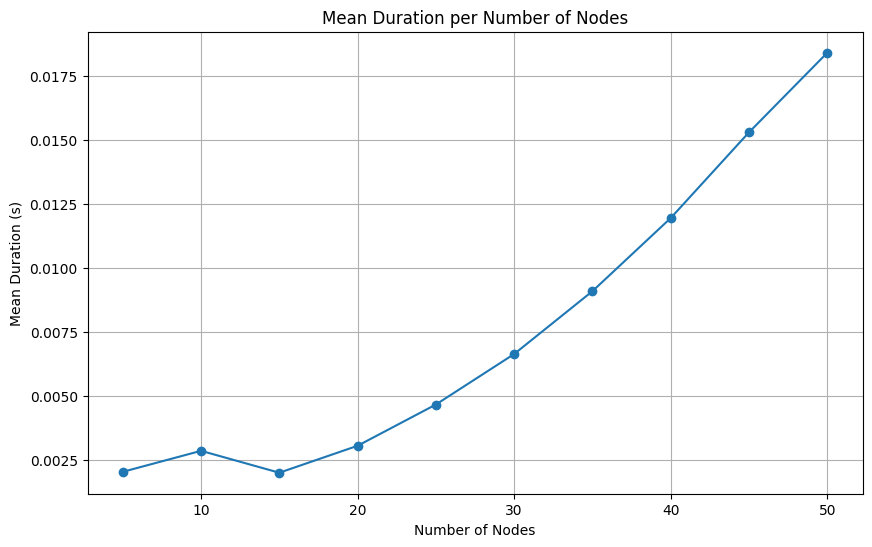

In [9]:
import argparse
import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from models.gcl import E_GCL, unsorted_segment_sum
from qm9.models import EGNN

parser = argparse.ArgumentParser()
parser.add_argument('--hidden_features', type=int, default=128)
parser.add_argument('--edge_features', type=int, default=1)
parser.add_argument('--out_features', type=int, default=1)
parser.add_argument('--n_layers', type=int, default=3)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--min_nodes', type=int, default=5)
parser.add_argument('--max_nodes', type=int, default=50)
parser.add_argument('--step_nodes', type=int, default=5)
parser.add_argument('--n_warmup', type=int, default=10)
parser.add_argument('--n_iter', type=int, default=100)
parser.add_argument('--n_measurements', type=int, default=10)
parser.add_argument('--output_file', type=str, default='timing_results.json')

#needed for collab
args, unknown = parser.parse_known_args()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We generate syntetic data for this experiment
def get_edges(n_nodes):
    rows, cols = [], []
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j:
                rows.append(i)
                cols.append(j)
    return [rows, cols]

def get_edges_batch(n_nodes, batch_size):
    edges = get_edges(n_nodes)
    edge_attr = torch.ones(len(edges[0]) * batch_size, 1).to(device)
    edges = [torch.LongTensor(edges[0]).to(device), torch.LongTensor(edges[1]).to(device)]
    if batch_size == 1:
        return edges, edge_attr
    elif batch_size > 1:
        rows, cols = [], []
        for i in range(batch_size):
            rows.append(edges[0] + n_nodes * i)
            cols.append(edges[1] + n_nodes * i)
        edges = [torch.cat(rows), torch.cat(cols)]
    return edges, edge_attr


def run_timing_test(n_nodes):
    durations = []

    node_features = torch.randn((args.batch_size * n_nodes, 15), dtype=torch.float).to(device)
    node_positions = torch.randn((args.batch_size * n_nodes, 3), dtype=torch.float).to(device)
    node_mask = torch.ones((args.batch_size * n_nodes, 1), dtype=torch.float).to(device)
    edges, edge_attr = get_edges_batch(n_nodes, args.batch_size)
    edge_mask = torch.ones(len(edges[0]), 1).to(device)  # edge_mask must match the number of edges

    model = EGNN(
        in_node_nf=15,
        in_edge_nf=args.edge_features,
        hidden_nf=args.hidden_features,
        device=device,
        n_layers=args.n_layers
    ).to(device)

    for measurement in tqdm.tqdm(range(args.n_measurements), desc=f'Nodes: {n_nodes}'):

        if measurement == 0:
            print(node_features.shape, node_positions.shape, edges[0].shape)
            print('Num. params:', sum(p.numel() for p in model.parameters() if p.requires_grad))

        for _ in range(args.n_warmup):
            _ = model(node_features, node_positions, edges, edge_attr, node_mask, edge_mask, n_nodes)
        torch.cuda.synchronize()

        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()
        for _ in range(args.n_iter):
            _ = model(node_features, node_positions, edges, edge_attr, node_mask, edge_mask, n_nodes)
        end.record()
        torch.cuda.synchronize()

        durations.append(0.001 * start.elapsed_time(end) / args.n_iter)

    mean_duration = np.mean(durations)
    std_duration = np.std(durations)

    return mean_duration, std_duration

results = []
node_counts = list(range(args.min_nodes, args.max_nodes + 1, args.step_nodes))

for n_nodes in node_counts:
    mean_duration, std_duration = run_timing_test(n_nodes)
    results.append({
        'n_nodes': n_nodes,
        'mean_duration': mean_duration,
        'std_duration': std_duration
    })
    print(f'Nodes: {n_nodes}, Mean Duration: {mean_duration:.5f} s, Std Duration: {std_duration:.6f} s')

with open(args.output_file, 'w') as f:
    json.dump(results, f)

mean_durations = [result['mean_duration'] for result in results]
plt.figure(figsize=(10, 6))
plt.plot(node_counts, mean_durations, marker='o')
plt.xlabel('Number of Nodes')
plt.ylabel('Mean Duration (s)')
plt.title('Mean Duration per Number of Nodes - EGNN Jax')
plt.grid(True)
plt.savefig('timing_plot.png')
plt.show()

## 4. Plotting the results

In [10]:
import json

with open('timing_results_jax_complete.json', 'r') as f:
    jax_results = json.load(f)

with open('timing_results_complete.json', 'r') as f:
    pytorch_results = json.load(f)

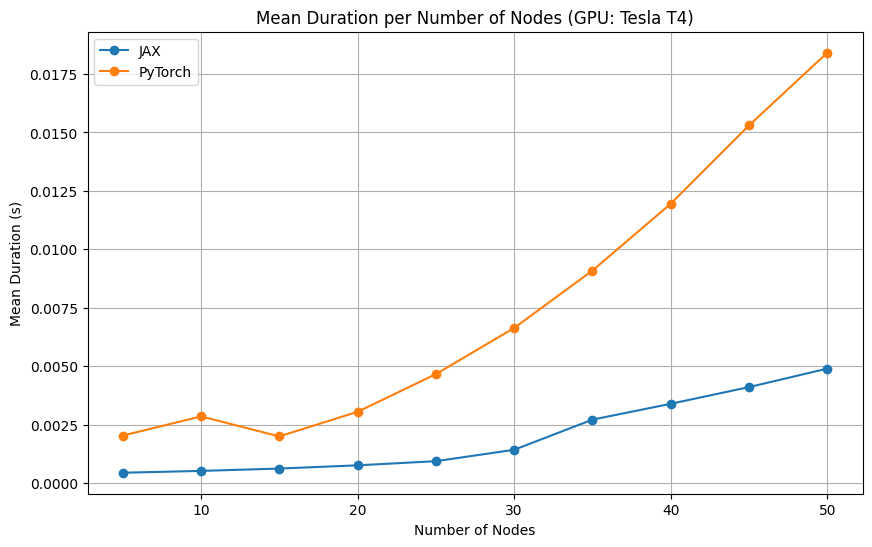

In [11]:
import matplotlib.pyplot as plt

jax_node_counts = [result['n_nodes'] for result in jax_results]
jax_mean_durations = [result['mean_duration'] for result in jax_results]

pytorch_node_counts = [result['n_nodes'] for result in pytorch_results]
pytorch_mean_durations = [result['mean_duration'] for result in pytorch_results]

# get session GPU info
gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader

plt.figure(figsize=(10, 6))
plt.plot(jax_node_counts, jax_mean_durations, marker='o', label='JAX')
plt.plot(pytorch_node_counts, pytorch_mean_durations, marker='o', label='PyTorch')
plt.xlabel('Number of Nodes')
plt.ylabel('Mean Duration (s)')
plt.title(f'Mean Duration per Number of Nodes (GPU: {gpu_info[0]})')
plt.legend()
plt.grid(True)
plt.savefig('timing_comparison_plot.png')
plt.show()


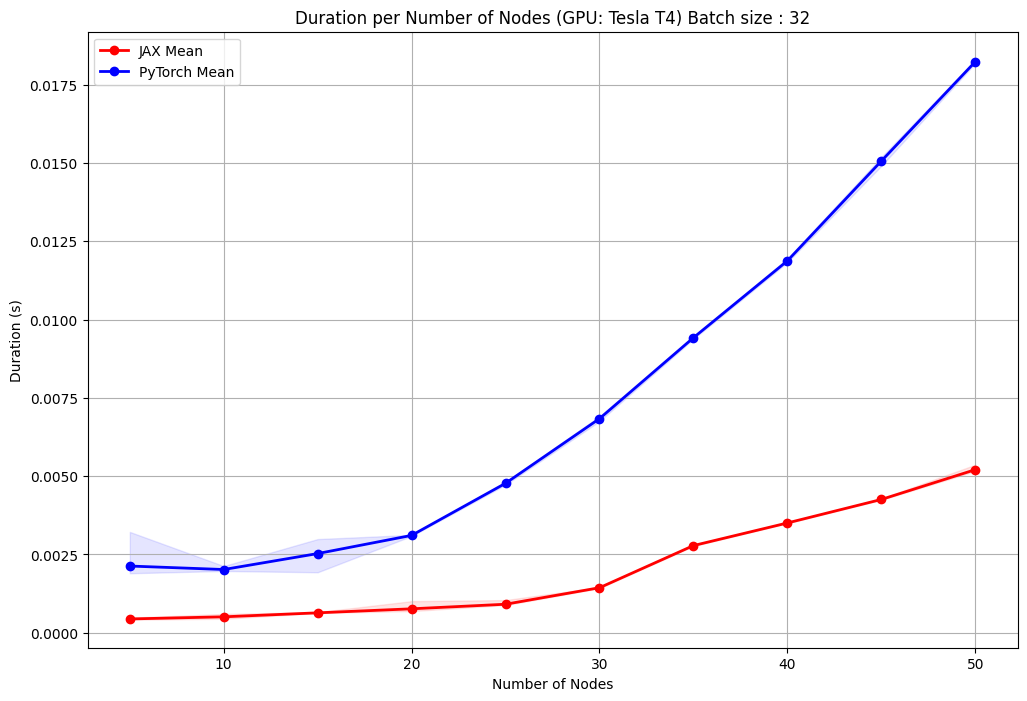

In [23]:
## use actual durations as a transparent mask for better insights
jax_node_counts = [result['n_nodes'] for result in jax_results]
jax_mean_durations = [result['mean_duration'] for result in jax_results]
jax_individual_durations = [result['durations'] for result in jax_results]

pytorch_node_counts = [result['n_nodes'] for result in pytorch_results]
pytorch_mean_durations = [result['mean_duration'] for result in pytorch_results]
pytorch_individual_durations = [result['durations'] for result in pytorch_results]

gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

jax_min_durations = [np.min(durations) for durations in jax_individual_durations]
jax_max_durations = [np.max(durations) for durations in jax_individual_durations]
plt.fill_between(jax_node_counts, jax_min_durations, jax_max_durations, color='red', alpha=0.1)

pytorch_min_durations = [np.min(durations) for durations in pytorch_individual_durations]
pytorch_max_durations = [np.max(durations) for durations in pytorch_individual_durations]
plt.fill_between(pytorch_node_counts, pytorch_min_durations, pytorch_max_durations, color='blue', alpha=0.1)

plt.plot(jax_node_counts, jax_mean_durations, marker='o', color='red', label='JAX Mean', linestyle='-', linewidth=2)

plt.plot(pytorch_node_counts, pytorch_mean_durations, marker='o', color='blue', label='PyTorch Mean', linestyle='-', linewidth=2)

plt.xlabel('Number of Nodes')
plt.ylabel('Duration (s)')
plt.title(f'Duration per Number of Nodes (GPU: {gpu_info[0]}) Batch size : 32')
plt.legend()
plt.grid(True)
plt.savefig('timing_comparison_plot.png')
plt.show()
